# Will You Accept This Analysis?
#### Danielle Eliav
Since 2002, millions of viewers tune in to watch what Chris Harrison promises will be "the most dramatic season" of The Bachelor(ette) yet. From jumping fences to fist fights to lots and lots of tears every season brings new [drama](https://www.thewrap.com/bachelor-bachelorette-moments-dramatic-moments-all-time-colton-barb/) to TVs all over the country. 

[For those unfamiliar](https://www.queensjournal.ca/story/2020-01-09/pop-culture/a-beginners-guide-to-viewing-the-bachelor/) with [The Bachelor franchise](https://en.wikipedia.org/wiki/The_Bachelor_(franchise)), the main shows, The Bachelor and The Bachelorette, feature a male or female lead, the bachelor or bachelorette respectively, looking for true love. Every season begins with 20-30 suitors arriving to compete for the attention and affection of the bachelor(ette). The first night, the bachelor(ette) gives out one (or occasionally many) first impression rose, allowing them to remain on the show for the second week, to the contestant(s) he/she feels made the best first impression. Every subsequent week, the lead goes on a few dates with one or a group of the contestants and gives out roses that represent them being chosen to remain on the show for another week. By the series finale, there are only two suitors remaining: one leaves heartbroken, the other leaves engaged to the lead and the two eventually get married.

At least that's the hope. In reality couples from the show rarely stay together long term and the authenticity of the show has been questioned on more than one occasion. Even so, the franchise continues to thrive with almost 40 seasons between The Bachelor and The Bachelorette as of when this was written. Needless to say, the show has amassed a dedicated following, referred to as "Bachelor Nation", and has inspired many to compete in leagues akin to those of fantasy football trying to create brackets that predict the outcome of every season. 


In this tutorial, we'll examine the success rate of the show and its relation to first impressions roses and the age of contestants. We'll also look at whether first impression roses are good predictors of the final two. 

## Data Collection

The first step is to collect the necessary data. We'll be collecting our data from Wikipedia. We'll collect the names and ages of each contestant and note their sex and which season they're from. We'll also collect the names of the winner and runner-up(s) of each season as well as whether the couple from that season got engaged and if they're still together. All of the data will be stored in a [Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html) dataframe and we'll use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to help with scraping the data.

Let's start with the information on the contestants. 

In [272]:
import re
import time
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import warnings; warnings.simplefilter('ignore')

def remove_footnotes(s):
    end = s.find('[')
    if end != -1:
        return s[:end]
    else:
        return s

def scrape_contestants(base_url, seasons, sex):

    result= []
        
    for i in range(1,seasons+1):
        current_url = base_url + str(i) + ')'
        print('checking {}'.format(current_url))
        response = requests.get(current_url)
        soup = BeautifulSoup(response.text, 'html.parser')
    
        if sex == 'M' and (i == 2 or i ==3): #two seasons of The Bachelorette have pages that are structured differently 
            contestants = soup.find('table',{'class':'wikitable'})
        else:
            contestants= soup.find('table',{'class':'wikitable sortable'})
                
        if contestants != None:
            contestants = contestants.find_all('tr')

            for contestant in contestants[1:]:
                contestant = contestant.find_all('td')
                
                result.append({
                    'name': remove_footnotes(contestant[0].text.strip()),
                    'age': remove_footnotes(contestant[1].text.strip()),
                    'sex': sex,
                    'season': i
                })
    
    return pd.DataFrame(result)

bachelor_URL = 'https://en.wikipedia.org/wiki/The_Bachelor_(American_season_'
bachelorette_URL   = 'https://en.wikipedia.org/wiki/The_Bachelorette_(season_'

# Data loaded from CSV to save time
# bachelor_contestants = scrape_contestants(bachelor_URL, 24, 'F')
# bachelorette_contestants = scrape_contestants(bachelorette_URL, 15, 'M')
# bachelor_contestants.to_csv('csv/bachelor_contestants.csv')
# bachelorette_contestants.to_csv('csv/bachelorette_contestants.csv')

bachelor_contestants = pd.read_csv('csv/bachelor_contestants.csv')
bachelorette_contestants = pd.read_csv('csv/bachelorette_contestants.csv')

contestants = pd.concat([bachelor_contestants, bachelorette_contestants], ignore_index=True).drop('Unnamed: 0', axis=1)
contestants.sample(5)

,name,age,sex,season
355,Kimberly Sherbach,28.0,F,19
311,Renee Oteri,32.0,F,18
364,Reegan Cornwell,28.0,F,19
207,Ashleigh Hunt,25.0,F,14
476,Devin Gooden,23.0,F,23


Now we have a pandas dataframe with the name, age, sex, and season of almost every contestant from The Bachelor and The Bachelorette. Seasons 3,4,6,7, and 8 of The Bachelor do not have contestant data available on Wikipedia, but we do have data from the remaining 33 seasons that have finished airing. 

Next we'll scrape the outcomes of each season. 

In [273]:
def scrape_seasons(URL, sex):
    response = requests.get(URL)
    soup = BeautifulSoup(response.text, 'html.parser')

    seasons= soup.find('table',{'class':'wikitable plainrowheaders'})
    result = []
    if seasons != None:
        seasons = seasons.find_all('tr')

        i = 1
        for season in seasons[1:]:
            season = season.find_all(['td','th'])

            if len(season) == 8 and not (sex == 'F' and i == 16 ): #season 16 of The Bachelorette is still airing

                
                result.append({
                    'sex' : sex,
                    'season': i,
                    'lead': remove_footnotes(season[2].text.strip()),
                    'winner': remove_footnotes(season[3].text.strip()),
                    'runner-up': remove_footnotes(season[4].text.strip()),
                    'engagement': (remove_footnotes(season[5].text.strip()) == 'Yes'),
                    'still_together': (remove_footnotes(season[6].text.strip()) == 'Yes')
                })
                i += 1
                
            else:
                if (sex == 'M' and  i < 25): #seasons that had two runner-ups (season 25 of The Bachelor hasn't aired yet)
                     result[i-2]['runner-up'] += ',' + remove_footnotes(season[0].text.strip())
                if (sex == 'F' and i == 11): #season 11 of The Bachelorette had the same runner-up as season 10
                    result.append({
                        'sex' : sex,
                        'season': i,
                        'lead': remove_footnotes(season[2].text.strip()),
                        'winner': remove_footnotes(season[3].text.strip()),
                        'runner-up': result[i-2]['runner-up'],
                        'engagement': (remove_footnotes(season[5].text.strip()) == 'Yes'),
                        'still_together': (remove_footnotes(season[6].text.strip()) == 'Yes')
                    })
                    i += 1

    return pd.DataFrame(result)

# Data loaded from csv to save time
# bachelor_seasons = scrape_seasons('https://en.wikipedia.org/wiki/The_Bachelor_(American_TV_series)', 'M')
# bachelor_seasons.to_csv('csv/bachelor_seasons.csv')

# bachelorette_seasons = scrape_seasons('https://en.wikipedia.org/wiki/The_Bachelorette', 'F')
# bachelorette_seasons.to_csv('csv/bachelorette_seasons.csv')

bachelor_seasons = pd.read_csv('csv/bachelor_seasons.csv')
bachelorette_seasons = pd.read_csv('csv/bachelorette_seasons.csv')

seasons = pd.concat([bachelor_seasons, bachelorette_seasons], ignore_index=True).drop('Unnamed: 0', axis=1)
seasons.sample(5)

,sex,season,lead,winner,runner-up,engagement,still_together
21,M,22,Arie Luyendyk Jr.,Becca Kufrin,Lauren Burnham,True,False
2,M,3,Andrew Firestone,Jen Schefft,Kirsten Buschbacher,True,False
32,F,9,Desiree Hartsock,Chris Siegfried,Drew Kenney,True,True
22,M,23,Colton Underwood,Cassie Randolph,"Hannah Godwin,Tayshia Adams",False,False
33,F,10,Andi Dorfman,Josh Murray,Nick Viall,True,False


Now we also have a dataframe with the name and sex of the lead of each season, the names of their winner and runner-up(s), if the couple left engaged, and if they're still together.

Lucky for us the data is already clean so we can just right in to analysis and see what we find!

## Data Analysis and Visualization
Let's start by looking at the number of seasons compared to the number of engagements and successful couples. To do this, we'll create a stacked bar graph using [matplotlib](https://matplotlib.org/3.1.0/api/index.html) with a bar for each show and the two combined.

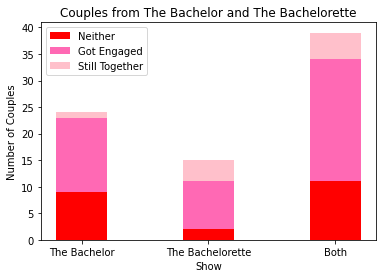

In [274]:
import matplotlib.pyplot as plt

N = 3

bachelor_seasons = seasons[seasons['sex'] == 'M']
num_seasons = (bachelor_seasons.sex.count())
num_engaged = bachelor_seasons[bachelor_seasons['engagement']].sex.count()
num_together = bachelor_seasons[bachelor_seasons['still_together']].sex.count()

bachelorette_seasons = seasons[seasons['sex'] == 'F']
num_seasons2 = (bachelorette_seasons.sex.count())
num_engaged2 = bachelorette_seasons[bachelorette_seasons['engagement']].sex.count()
num_together2 = bachelorette_seasons[bachelorette_seasons['still_together']].sex.count()

neither = ((num_seasons - num_engaged), (num_seasons2 - num_engaged2), (num_seasons - num_engaged) + (num_seasons2 - num_engaged2))
engaged = ((num_engaged - num_together), (num_engaged2 - num_together2), ((num_engaged - num_together) + (num_engaged2 - num_together2)))
together = (num_together, num_together2, num_together + num_together2 )

ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, neither, width, color = 'red')
p2 = plt.bar(ind, engaged, width, bottom=neither, color = 'hotpink')
p3 = plt.bar(ind, together, width, bottom=(num_seasons - num_together, num_seasons2 - num_together2, (num_seasons - num_together + num_seasons2 - num_together2)), color = 'pink')

plt.ylabel('Number of Couples')
plt.xlabel('Show')
plt.title('Couples from The Bachelor and The Bachelorette')
plt.xticks(ind, ('The Bachelor', 'The Bachelorette', 'Both'))
plt.yticks(np.arange(0, 45, 5))
plt.legend((p1[0], p2[0], p3[0]), ('Neither', 'Got Engaged', 'Still Together'))

plt.show()

Based on our graph, it's clear that not many couples from the franchise stay together. Although a lot of seasons end in an engagement, those rarely last.
This graph gives us some insight into the success rates, but a graph showing the percentages would probably be more helpful. Luckily that's an easy adjustment.

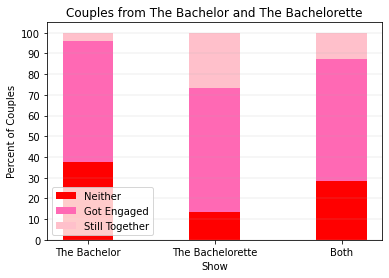

In [275]:
from operator import mul 
from operator import add

N = 3

bachelor_seasons = seasons[seasons['sex'] == 'M']
num_seasons = (bachelor_seasons.sex.count())
num_engaged = bachelor_seasons[bachelor_seasons['engagement']].sex.count()
num_together = bachelor_seasons[bachelor_seasons['still_together']].sex.count()

bachelorette_seasons = seasons[seasons['sex'] == 'F']
num_seasons2 = (bachelorette_seasons.sex.count())
num_engaged2 = bachelorette_seasons[bachelorette_seasons['engagement']].sex.count()
num_together2 = bachelorette_seasons[bachelorette_seasons['still_together']].sex.count()

neither = ((num_seasons - num_engaged), (num_seasons2 - num_engaged2), (num_seasons - num_engaged) + (num_seasons2 - num_engaged2))
engaged = ((num_engaged - num_together), (num_engaged2 - num_together2), ((num_engaged - num_together) + (num_engaged2 - num_together2)))
together = (num_together, num_together2, num_together + num_together2)

to_percent = (100/num_seasons, 100/num_seasons2, 100/(num_seasons + num_seasons2))

pneither = tuple(map(mul, neither, to_percent))
pengaged = tuple(map(mul, engaged, to_percent))
ptogether = tuple(map(mul, together, to_percent))


ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pneither, width, color = 'red')
p2 = plt.bar(ind, pengaged, width, bottom=pneither, color = 'hotpink')
p3 = plt.bar(ind, ptogether, width, bottom=tuple(map(add, pengaged, pneither)), color = 'pink')

plt.ylabel('Percent of Couples')
plt.xlabel('Show')
plt.title('Couples from The Bachelor and The Bachelorette')
plt.xticks(ind, ('The Bachelor', 'The Bachelorette', 'Both'))
plt.yticks(np.arange(0, 101, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Neither', 'Got Engaged', 'Still Together'))
plt.grid(b=True, axis='y', lw=.2)
plt.show()

Now we can clearly see that almost 30% of couples from The Bachelorette stay together while less than 5% of couples from The Bachelor stay together. Across both shows, 70% of seasons end with an engagement but only 10% of couples stay together. 

Many in Bachelor Nation complain at the young age of the contestants in some seasons. Let's look at the average age of contestants through the seasons and see if it's correlated to whether or not the couple is successful.

Let's start with a line graph of the average age of contestants throughout the seasons of the shows. Since our previous graph showed drastically different data between the two shows, we'll continue to split them up.

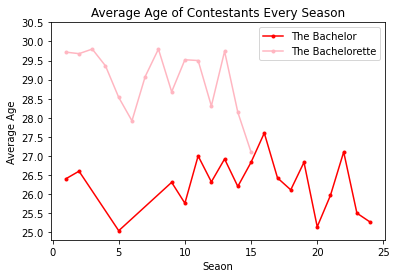

In [276]:
grouped = contestants.groupby(by=['sex','season']).mean().reset_index()

x = grouped[grouped['sex'] == 'F'].season
y = grouped[grouped['sex'] == 'F'].age

plt.plot(x,y, label='The Bachelor', color='red', marker='.')

x = grouped[grouped['sex'] == 'M'].season
y = grouped[grouped['sex'] == 'M'].age

plt.plot(x,y,label='The Bachelorette',color='lightpink', marker='.')
plt.yticks(np.arange(25, 31, .5))
plt.ylabel('Average Age')
plt.xlabel('Seaon')
plt.title('Average Age of Contestants Every Season')
plt.legend()


It looks like contestants on The Bachelorette tend to be older than those on the The Bachelor and there has been a downward trend in recent seasons. I wonder if the older age of the contestants on The Bachelorette is related to the success rate of the show. Let's take a closer look at the distribution of ages on the two shows on successful seasons vs. unsuccessful seasons. This time we're gonna use [seaborn](https://seaborn.pydata.org/introduction.html) to make a violin graph.

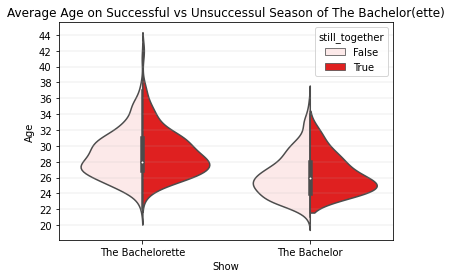

In [277]:
import seaborn as sns

# seasons['sex'] = seasons['sex'] == 'M'
# contestants['sex'] = (contestants['sex'] == 'F')
# merged = contestants.merge(seasons, how='left', on = ['sex', 'season'])
plot = sns.violinplot(x='sex', y="age", hue="still_together",data=merged, split=True, color='red')
plot.set_title('Average Age on Successful vs Unsuccessul Season of The Bachelor(ette)')
plot.set_ylabel('Age')
plot.set_xlabel('Show')
plot.set_xticklabels(['The Bachelorette', 'The Bachelor'])
plt.yticks(np.arange(20, 45, 2))
plt.grid(b=True, axis='y', lw=.2)


Although the average contestant on The Bachelorette is two years older than the average contestant on The Bachelor, there does not seem to be a significant difference in the age of contestants on seasons in which the couple stayed together and those where the couple didn't. 
Even though age doesn't seem to be a good predictor of how successful a season will be, perhaps first impression roses will be a better predictor of the final two.
Before we can do that analysis though, we're going to need to grab some more data; namely, who got the first impression rose(s) each season.

## Data Collection (again)
Lucky for us, Wikipedia has information on all the roses given out every season. The charts only use first names and, when necessary, last initials so we're first going to have to reformat the names of the winners and runner-ups we scraped before to be able to make the comparisons.

In [278]:
name = seasons['winner'].str.split(" ",n=2, expand = True)
seasons['winner_first'] = name[0]
seasons['winner_lasti'] = name[1].str[0] +'.'

names = seasons['runner-up'].str.split(",")
# print([name for names in names for name in names])
season_firsts = []
season_lastis = []
for names in seasons['runner-up'].str.split(','):
    parts = [name.split(' ') for name in names]
    season_firsts.append([part[0] for part in parts])
    season_lastis.append([part[1][0] for part in parts])
    
seasons['second_first'] = [','.join(firsts) for firsts in season_firsts]
seasons['second_lasti'] = ['.,'.join(lastis)+'.' for lastis in season_lastis]



seasons.at[19, 'second_first'] = 'Jojo'
seasons.at[19, 'second_lasti'] = 'F.'
seasons.at[23, 'winner_lasti'] = 'Ann'
seasons.sample(5)

,sex,season,lead,winner,runner-up,engagement,still_together,winner_first,winner_lasti,second_first,second_lasti
7,M,8,Travis Lane Stork,Sarah Stone,Moana Dixon,False,False,Sarah,S.,Moana,D.
13,M,14,Jake Pavelka,Vienna Girardi,Tenley Molzahn,True,False,Vienna,G.,Tenley,M.
19,M,20,Ben Higgins,Lauren Bushnell,"Joelle ""JoJo"" Fletcher",True,False,Lauren,B.,Jojo,F.
10,M,11,Brad Womack,NaN,"Jenni Croft,DeAnna Pappas",False,False,NaN,NaN,"Jenni,DeAnna","C.,P."
18,M,19,Chris Soules,Whitney Bischoff,Becca Tilley,True,False,Whitney,B.,Becca,T.


Some of the contestants were referred to by a nickname or have to first names so I adjusted those manually. Now we're ready to scrape who got the first impression roses.

In [279]:
def scrape_roses(df):
    bachelor_URL = 'https://en.wikipedia.org/wiki/The_Bachelor_(American_season_'
    bachelorette_URL   = 'https://en.wikipedia.org/wiki/The_Bachelorette_(season_'
    w_first = [] #if the winner recieved a first impression rose 
    ru_first = [] #if the runner-up recieved a first impression rose
    
    for i,row in df.iterrows():
        if row['sex'] == 'M':
            url = bachelor_URL
        else:
            url = bachelorette_URL
        
        url += str(row['season']) + ')'
        
#         print('checking {}'.format(url))
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
    
        roses = soup.find(id=["Elimination_Chart","Call-Out_Order", "Call-out_order"])
       
        if roses != None:
            roses = roses.find_parent().find_next_sibling('table')
            roses = roses.find_all('tr')[2:]
            
            name = roses[0].find_all('td')[1].text.strip().split(' ', 2)
            rufirst= row['second_first'].split(',')
            rulast = row['second_lasti'].split(',')
            
            if name[0] == row['winner_first'] and (len(name) == 1 or name[1] == row['winner_lasti']):
                w_first.append(True)
            elif len(rufirst) >1:
                if name[0] == rufirst[0] and (len(name) == 1 or name[1] == rulast[0]):
                    ru_first.append(True)
                elif name[0] == rufirst[1] and (len(name) == 1 or name[1] == rulast[1]):
                    ru_first.append(True)
            elif name[0] == row['second_first'] and (len(name) == 1 or name[1] == row['second_lasti']):
                ru_first.append(True)
            
            j = 1
            while ('skyblue' in str(roses[j].find_all('td')[1].attrs) or 'orange' in str(roses[j].find_all('td')[1].attrs) ):
                name = roses[j].find_all('td')[1].text.strip().split(' ', 2)
                rufirst= row['second_first'].split(',')
                rulast = row['second_lasti'].split(',')
                if name[0] == row['winner_first'] and (len(name) == 1 or name[1] == row['winner_lasti']):
                    w_first.append(True)
                elif len(rufirst) >1:
                    if name[0] == rufirst[0] and (len(name) == 1 or name[1] == rulast[0]):
                        ru_first.append(True)
                    elif name[0] == rufirst[1] and (len(name) == 1 or name[1] == rulast[1]):
                        ru_first.append(True)
                elif name[0] == row['second_first'] and (len(name) == 1 or name[1] == row['second_lasti']):
                    ru_first.append(True)
                j += 1
            
            if len(w_first) != i+1:
                w_first.append(False)
            if len(ru_first) != i+1:
                ru_first.append(False)
    df['winner_fi'] = w_first
    df['second_fi'] = ru_first
        
    return df

# seasons = seasons.drop(2).drop(3).drop(5).drop(6).drop(7).reset_index(drop = True)

# roses = scrape_roses(seasons)
# roses.to_csv('csv/roses.csv')

roses = pd.read_csv('csv/roses.csv').drop('Unnamed: 0', axis=1)
roses.sample(5)

,sex,season,lead,winner,runner-up,engagement,still_together,winner_first,winner_lasti,second_first,second_lasti,winner_fi,second_fi
12,M,18,Juan Pablo Galavis,Nikki Ferrell,Clare Crawley,False,False,Nikki,F.,Clare,C.,False,False
4,M,10,Andrew Baldwin,Tessa Horst,Bevin Nicole Powers,True,False,Tessa,H.,Bevin,N.,False,False
23,F,5,Jillian Harris,Ed Swiderski,Kiptyn Locke,True,False,Ed,S.,Kiptyn,L.,False,False
13,M,19,Chris Soules,Whitney Bischoff,Becca Tilley,True,False,Whitney,B.,Becca,T.,False,False
29,F,11,Kaitlyn Bristowe,Shawn Booth,Nick Viall,False,False,Shawn,B.,Nick,V.,True,False


## Back to Analysis
Now we can look at what percentage of finalists received a first impression rose. Once again we'll use a stacked bar chart.

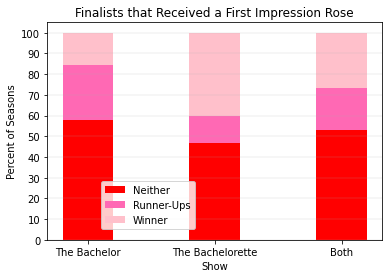

In [280]:
from operator import sub

N = 3

bachelor_seasons = roses[roses['sex'] == 'M']
num_seasons = (bachelor_seasons.sex.count())
num_w = bachelor_seasons[bachelor_seasons['winner_fi']].sex.count() - num_both
num_ru = bachelor_seasons[bachelor_seasons['second_fi']].sex.count() - num_both
num_neither = num_seasons - num_w - num_ru

bachelorette_seasons = roses[roses['sex'] == 'F']
num_seasons2 = (bachelorette_seasons.sex.count())
num_w2 = bachelorette_seasons[bachelorette_seasons['winner_fi']].sex.count() - num_both2
num_ru2 = bachelorette_seasons[bachelorette_seasons['second_fi']].sex.count() - num_both2
num_neither2 = num_seasons2 - num_w2 - num_ru2

winner = (num_w, num_w2, num_w+num_w2)
ru = (num_ru, num_ru2, num_ru + num_ru2)
neither = (num_neither, num_neither2, num_neither+num_neither2)

to_percent = (100/num_seasons, 100/num_seasons2, 100/(num_seasons + num_seasons2))

pneither = tuple(map(mul, neither, to_percent))
pwinner = tuple(map(mul, winner, to_percent))
pru = tuple(map(mul, ru, to_percent))

ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pneither, width, color = 'red')
p2 = plt.bar(ind, pru, width, bottom=pneither, color = 'hotpink')
p3 = plt.bar(ind, pwinner, width, bottom=tuple(map(add, pru, pneither)), color = 'pink')

plt.ylabel('Percent of Seasons')
plt.xlabel('Show')
plt.title('Finalists that Received a First Impression Rose')
plt.xticks(ind, ('The Bachelor', 'The Bachelorette', 'Both'))
plt.yticks(np.arange(0, 101, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Neither', 'Runner-Ups', 'Winner'), loc=(.16,.05))
plt.grid(b=True, axis='y', lw=.2)
plt.show()

For those making brackets, putting contestants that get a first impression rose in the finale isn't a bad bet, especially for The Bachelorette. With over 50% of finalists, including 40% of winners from the Bachelorette being recipients of a first impression rose, it's safe to say bachelorettes on the show tend to trust their insticts. 

These numbers are based on the first rose, or roses if they were labeled as first impressions roses, given out on the first night, but it turns out the tradition of first-impression roses didn't start until season 10 of The Bachelor and season 3 of The Bachelorette. Will this change the resutls?

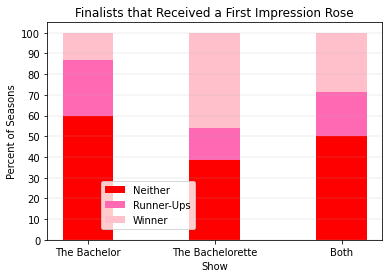

In [281]:
N = 3

bachelor_seasons = roses[roses['sex'] == 'M'][roses['season'] >= 10]
num_seasons = (bachelor_seasons.sex.count())
num_w = bachelor_seasons[bachelor_seasons['winner_fi']].sex.count() - num_both
num_ru = bachelor_seasons[bachelor_seasons['second_fi']].sex.count() - num_both
num_neither = num_seasons - num_w - num_ru

bachelorette_seasons = roses[roses['sex'] == 'F'][roses['season'] >=3]
num_seasons2 = (bachelorette_seasons.sex.count())
num_w2 = bachelorette_seasons[bachelorette_seasons['winner_fi']].sex.count() - num_both2
num_ru2 = bachelorette_seasons[bachelorette_seasons['second_fi']].sex.count() - num_both2
num_neither2 = num_seasons2 - num_w2 - num_ru2

winner = (num_w, num_w2, num_w+num_w2)
ru = (num_ru, num_ru2, num_ru + num_ru2)
neither = (num_neither, num_neither2, num_neither+num_neither2)

to_percent = (100/num_seasons, 100/num_seasons2, 100/(num_seasons + num_seasons2))

pneither = tuple(map(mul, neither, to_percent))
pwinner = tuple(map(mul, winner, to_percent))
pru = tuple(map(mul, ru, to_percent))

ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pneither, width, color = 'red')
p2 = plt.bar(ind, pru, width, bottom=pneither, color = 'hotpink')
p3 = plt.bar(ind, pwinner, width, bottom=tuple(map(add, pru, pneither)), color = 'pink')

plt.ylabel('Percent of Seasons')
plt.xlabel('Show')
plt.title('Finalists that Received a First Impression Rose')
plt.xticks(ind, ('The Bachelor', 'The Bachelorette', 'Both'))
plt.yticks(np.arange(0, 101, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Neither', 'Runner-Ups', 'Winner'), loc=(.16,.05))
plt.grid(b=True, axis='y', lw=.2)
plt.show()

There was no noticable difference in The Bachelor data, but even more bachelorettes than we calculated previously gave their winners first impression roses at the start of the show. But was it truly love at first sight? And is it true that "when you know, you know" like people say?

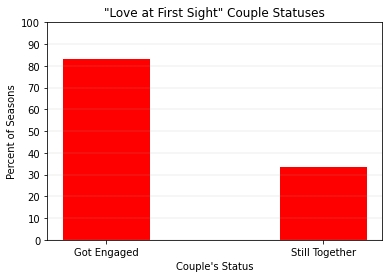

In [282]:
N=2
bachelorette_seasons = roses[roses['sex'] == 'F'][roses['season'] >=3][roses['winner_fi']]

num_seasons = (bachelorette_seasons.sex.count())
num_engaged = bachelorette_seasons[bachelorette_seasons['engagement']].sex.count()
num_together = bachelorette_seasons[bachelorette_seasons['still_together']].sex.count()

percents = (num_engaged*100/num_seasons, num_together*100/num_seasons)

ind = np.arange(N)    
width = 0.4       

p1 = plt.bar(ind, percents, width, color = 'red')
plt.ylabel('Percent of Seasons')
plt.xlabel("Couple's Status")
plt.title('"Love at First Sight" Couple Statuses')
plt.xticks(ind, ('Got Engaged', 'Still Together'))
plt.yticks(np.arange(0, 101, 10))
plt.grid(b=True, axis='y', lw=.2)
plt.show()

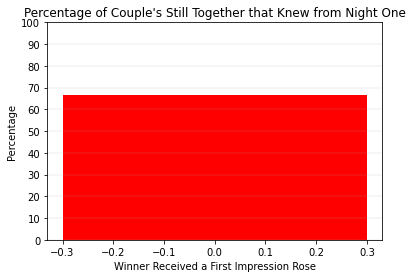

In [283]:
N=1
bachelorette_seasons = roses[roses['sex'] == 'F'][roses['season'] >=3][roses['still_together']]

num_seasons = (bachelorette_seasons.sex.count())
fi = bachelorette_seasons[bachelorette_seasons['winner_fi']].sex.count()


ind = np.arange(N)  
width = 0.6

p1 = plt.bar(ind, fi*100/num_seasons, width, color = 'red')
plt.ylabel('Percentage')
plt.xlabel("Winner Received a First Impression Rose")
plt.title('Percentage of Couple\'s Still Together that Knew from Night One')
plt.yticks(np.arange(0, 101, 10))
plt.grid(b=True, axis='y', lw=.2)
plt.show()

Looks like bachelorette's should pay less attention to first impressions. Although a lot of the couples get engaged, only about 30% stay together.

## Conclusion
After looking at all the data, it's pretty clear that couples from the show rarely last long term. Even though over 70% of couples from the franchise get engaged, only about 10% are still together. It's interesting that The Bachelorette has a higher success rate than The Bachelor and it would be interesting to do further research why that is. Based on our data, the older age of the contestants on The Bachelorette doesn't seem to be a factor. Perhaps the bachelorettes instantly know if one of the contestants is right for them. After all, for almost 70% of the couples from the Bachelorette the bachelorette gave the man a first impression rose on night one.

It would also be interesting to look at if the order that roses are given out at the rose ceremoies correlates to how far contestants get, instead of only looking at the first impression roses from night one. Additionally, for the purpose of creating accurate brackets, it would be interesting to look at how far different races tend to get and what other factors can predict how far contestants get. 

Lastly, even though The Bachelor and The Bachelorette don't have particularly high success rates, it would be interesting to look at how successful Bachelor Franchise (including on the spinoff shows) is at finding love for its participants. 
If we're all being honest though, their could be zero successul couples from the franchise and Bachlor Nation would still tune in every week to hear Chris Harrison say, "this is the final rose tonight."